In [1]:
DEFAULT_PARAMS = {
    'max_depth': 5,
    'n_trees': 5,
    "train_path": "breast-train-0-s1.csv",
    "test_path": "breast-test-0-s1.csv",
    "cv": 2,
    "cv_repeats": 5,
    "n_jobs": -1,
    'n_gen': 20,
    'pop_size': 100,
    'debug': False,
}

In [2]:
from box import Box

if 'params' in vars():
    params = Box({**DEFAULT_PARAMS, **params})
else:
    params = Box(DEFAULT_PARAMS)

In [4]:

from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd

# Load data

In [5]:
train_data = pd.read_csv(params['train_path'])
test_data = pd.read_csv(params['test_path'])
x_train = train_data.drop('TARGET', axis=1).values
y_train = train_data['TARGET'].values
x_test = test_data.drop('TARGET', axis=1).values
y_test = test_data['TARGET'].values

# Train base

In [7]:
from more_itertools import grouper

In [8]:
def list_with_repeated_elements(input_list, n_repeated):
    return [val for val in input_list for _ in range(n_repeated)]

In [9]:
from sklearn.model_selection import cross_validate, RepeatedKFold

In [10]:
feature_min = np.min(x_train, axis=0)
feature_max = np.max(x_train, axis=0)

In [11]:
from rules.classification.competence_region_ensemble import SimpleCompetenceRegionEnsemble

In [12]:
from sklearn.neighbors import NearestNeighbors

In [14]:
def nn_wrapper(nn):
    return Box({
     "predict": lambda x: nn.kneighbors(x, n_neighbors=nn.n_samples_fit_, return_distance=False)   
    })

In [15]:
def create_estimator(centroids, depths): 
    activated_trees_indices = np.nonzero(depths)[0]

    active_centroids = centroids[activated_trees_indices]
    active_depths = depths[activated_trees_indices]
    
    space_classifier = NearestNeighbors()
    space_classifier.fit(active_centroids)

    model = SimpleCompetenceRegionEnsemble(
        None,
        {label:DecisionTreeClassifier(max_depth=depth, random_state=42) for label, depth in enumerate(active_depths)}
    )
    
    return model, space_classifier


In [16]:
def find_closeset_val(arr, val):
    return np.argmin(np.abs(np.array(arr) - val))

# Problem

Wektor = $[\text{wspolrzedne}_n, \text{depth}_n, \text{wlaczony}_n]$

In [ ]:
# def create_mask(n_trees, n_dimensions):
#     return ['real'] * n_dimensions * n_trees + ['real'] * n_trees

In [ ]:
# OPERATORS = {
#     'sampling': {
#         'bin': 'bin_random',
#         'real': 'real_random',
#         'int': 'int_random'
#     }, 
#     'mutation': {
#         'bin': 'bin_bitflip',
#         'real': 'real_pm',
#         'int': 'int_pm',
#     },
#     'crossover': {
#         'bin': 'bin_one_point',
#         'real': 'real_sbx',
#         'int': 'int_sbx',
#     }
# }

In [17]:
n_dim = x_train.shape[1] 
n_trees = params.n_trees

In [ ]:

# from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover


In [ ]:
# mask = create_mask(n_trees, n_dim)
# variable_types = np.unique(mask)


In [ ]:
# sampling = MixedVariableSampling(mask, {
#     variable_type: get_sampling(OPERATORS['sampling'][variable_type]) for variable_type in variable_types
# })
# crossover = MixedVariableCrossover(mask, {
#     variable_type: get_crossover(OPERATORS['crossover'][variable_type]) for variable_type in variable_types
# })
# mutation = MixedVariableMutation(mask, {
#     variable_type: get_mutation(OPERATORS['mutation'][variable_type]) for variable_type in variable_types
# })

In [18]:
import numpy as np
from toolz.curried import pipe
from pymoo.core.problem import ElementwiseProblem
from loguru import logger


class MyProblem(ElementwiseProblem):

    def __init__(self, n_trees, x_train, y_train, max_tree_depth, **kwargs):
        n_dim = x_train.shape[1]
        
        super().__init__(
            n_var=n_trees*n_dim + n_trees, # each centroid * number of features + depths + on/off
             n_obj=1, # accuracy
             n_constr=0,
             xl=list(np.min(x_train, axis=0)) * n_trees + n_trees * [-0.5],
             xu=list(np.max(x_train, axis=0)) * n_trees + n_trees * [max_tree_depth + 0.5],
            **kwargs
        )
        
        
        self.n_trees = n_trees
        self.x_train = x_train
        self.y_train = y_train
        self.n_dim = n_dim
        self.max_tree_depth = max_tree_depth
        
    def _evaluate(self, individual, out, *args, **kwargs):
        n_coordinates_in_individual = self.n_dim * self.n_trees
        centroid_coordinates = individual[:n_coordinates_in_individual]
        
        individual_as_centroids = pipe(
            centroid_coordinates,
            lambda x: grouper(x, self.n_dim),
            list,
            np.array,
            np.nan_to_num
        )
        
        tree_depths_continous = individual[-self.n_trees:]
        possible_tree_depths = list(range(self.max_tree_depth + 1))
        
        tree_depths = np.array([find_closeset_val(possible_tree_depths, td) for td in tree_depths_continous])

        if np.all(tree_depths==0):
            out["F"] = 1
        else:
            model, space_classifier = create_estimator(individual_as_centroids, tree_depths)

            skf = RepeatedKFold(n_splits=params['cv'], n_repeats=params['cv_repeats'], random_state=42)
            scores = cross_validate(model, self.x_train, self.y_train, n_jobs=params['n_jobs'], scoring='accuracy', cv=skf, fit_params={
            'competence_region_classifier': nn_wrapper(space_classifier)
            })
            
            if params.debug:
                print(f"Depths = {tree_depths}, acc = {scores['test_score'].mean()}")

            out["F"] = 1 - scores['test_score'].mean()



In [19]:
import sys
logger.remove()
logger.add(sys.stderr, level="INFO")

1

In [22]:

from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import StarmapParallelization
from multiprocessing.pool import ThreadPool



pool = ThreadPool(params['pop_size'])
parallelization = StarmapParallelization(pool.starmap)


problem = MyProblem(params.n_trees, x_train, y_train, params.max_depth, elementwise_runner=parallelization
                   )

 
res = minimize(problem,
           GA(
               pop_size=10,
               verbose=True,
               seed=42,
                eliminate_duplicates=True
           ),
           ("n_gen", 10),
           verbose=True,
               save_history=True,
           seed=42)

pool.close()

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  0.3111594203 |  0.2652173913
     2 |       20 |  0.3000000000 |  0.2652173913
     3 |       30 |  0.2902898551 |  0.2652173913
     4 |       40 |  0.2839130435 |  0.2637681159
     5 |       50 |  0.2820289855 |  0.2637681159
     6 |       60 |  0.2723188406 |  0.2637681159
     7 |       70 |  0.2633333333 |  0.2434782609
     8 |       80 |  0.2530434783 |  0.2434782609
     9 |       90 |  0.2463768116 |  0.2434782609
    10 |      100 |  0.2434782609 |  0.2434782609


In [23]:
from sklearn.metrics import accuracy_score

In [24]:
res.exec_time

5.173154830932617

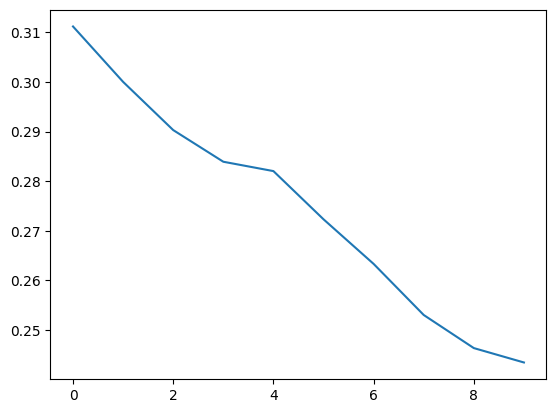

In [25]:
# import matplotlib.pyplot as plt
# val = [np.average(e.pop.get("F")) for e in res.history]
# plt.plot(np.arange(len(val)), val)
# plt.show()


In [ ]:
for idx, vals in enumerate([e.pop.get("F") for e in res.history]):
    mlflow.log_metrics(
        {'min_function_value': np.min(vals), 
         'avg_function_value': np.average(vals),
         'max_function_value': np.max(vals)
        }, step=idx)

In [27]:
if res.X.ndim == 1:
    pareto_front = [res.X]
else:
    pareto_front = res.X

In [28]:
accs = []
for individual in pareto_front:
    n_coordinates_in_individual = n_dim * n_trees
    centroid_coordinates = individual[:n_coordinates_in_individual]

    individual_as_centroids = pipe(
        centroid_coordinates,
        lambda x: grouper(x, n_dim),
        list,
        np.array,
        np.nan_to_num
    )
        
    tree_depths_continous = individual[-n_trees:]
    possible_tree_depths = list(range(params.max_depth + 1))
        
    tree_depths = np.array([find_closeset_val(possible_tree_depths, td) for td in tree_depths_continous])

    if params.debug:
        print(f"Depths = {tree_depths}")

    if np.all(tree_depths==0):
        continue
    else:
        model, space_classifier = create_estimator(individual_as_centroids, tree_depths)
        model.fit(x_train, y_train, competence_region_classifier=nn_wrapper(space_classifier))
    
        accs.append(accuracy_score(y_test, model.predict(x_test)))

In [29]:
accs

[0.7410071942446043]

In [ ]:
mlflow.log_metric('best_training_model_acc', 1 - min(res.F))
mlflow.log_metric('best_model_acc', max(accs))

In [ ]:
accs

In [ ]:
mlflow.log_params(params)

In [ ]:
import json

In [ ]:
mlflow.log_param("centroids", json.dumps(individual_as_centroids.tolist()))

In [ ]:
mlflow.end_run()